# Проект "Дашборд конверсий"

In [195]:
import os
import pandas as pd
import requests
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
pd.options.mode.chained_assignment = None  # default='warn'

## Получаем данные по регистрациям и посещениям по API, по рекламным кампаниям из CSV на drive.google.com

In [106]:
#Данные по посещениям
req_visits = requests.get('https://data-charts-api.hexlet.app/visits?begin=2023-03-01&end=2023-09-01')
df_visits = pd.DataFrame(req_visits.json())

#Данные по регистрациям
req_registrations = requests.get('https://data-charts-api.hexlet.app/registrations?begin=2023-03-01&end=2023-09-01')
df_registrations = pd.DataFrame(req_registrations.json())

#Данные по по рекламным кампаниям
df_ads = pd.read_csv('https://drive.google.com/uc?id=12vCtGhJlcK_CBcs8ES3BfEPbk6OJ45Qj')

## Агрегируем данные по регистрациям и посещениям и сохраняем полученный датафрейм в conversion.json

In [107]:
#Агрегируем данные по посещениям

##Группируем по visit_id, берем только последнее посещение
df_visits['datetime'] = pd.to_datetime(df_visits['datetime'])
df_visits_last = df_visits.loc[df_visits.groupby('visit_id')['datetime'].idxmax()]

##Отфильтровываем посещения ботов
df_visits_filtered = df_visits_last[~df_visits_last['user_agent'].str.contains('bot', case=False)]

##Группируем посещения по дате и платформе
df_visits_filtered['datetime'] = df_visits_filtered['datetime'].dt.strftime('%Y-%m-%d')
df_visits_grouped = df_visits_filtered.groupby(['datetime', 'platform']).size().reset_index(name='visits')

##Переименовываем столбцы согласно заданию
df_visits_grouped.columns = ['date_group', 'platform', 'visits']

#Агрегируем данные по регистрациям
##Группируем регистрации по дате и платформе
df_registrations['date_group'] = pd.to_datetime(df_registrations['datetime']).dt.strftime('%Y-%m-%d')
df_registrations_grouped = df_registrations.groupby(['date_group', 'platform']).size().reset_index(name='registrations')

#Объединяем датасэты
df_conversions = pd.merge(df_visits_grouped, df_registrations_grouped, on=['date_group', 'platform'], how='outer')

#Считаем конверсию из посещений в регистрацию
df_conversions['conversion'] = (df_conversions['registrations'] * 100 / df_conversions['visits']).round(2)

#Сортируем строки согласно заданию
df_conversions = df_conversions.sort_values(by='date_group')

#Сохраняем полученный датафрейм в формате JSON
df_conversions.to_json('conversion.json')

## Агрегируем данные по рекламным кампаниям и сохраняем полученный датафрейм в ads.json

In [115]:
#Группируем рекламу по дате и компании, считаем стоимость
df_ads['date_group'] = pd.to_datetime(df_ads['date']).dt.strftime('%Y-%m-%d')
df_ads_grouped = df_ads.groupby(['date_group']).agg({'cost': 'sum', 'utm_campaign': 'first'}).reset_index()

#Объединяем полученный датафрейм с df_conversions
df_ads_result = pd.merge(df_conversions, df_ads_grouped, on='date_group', how='left')

#Заполняем пустые значения в датафрейме
df_ads_result['cost'] = df_ads_result['cost'].fillna(0)
df_ads_result['utm_campaign'] = df_ads_result['utm_campaign'].fillna('none')

#Сортируем строки согласно заданию
df_ads_result = df_ads_result.sort_values(by='date_group')

#Сохраняем полученный датафрейм в формате JSON
df_ads_result.to_json('ads.json')

# Создаем директорию для выгрузки графиков в формате PNG, устанавливаем временной интервал для визуализации

In [125]:
try:
    os.makedirs('./charts')
except FileExistsError:
    print('Невозможно создать директорию, так как она уже существует')

df_by_dates = df_ads_result[(df_ads_result['date_group'].astype(str) >= '2023-03-01') & (df_ads_result['date_group'].astype(str) <= '2023-04-30')]

Невозможно создать директорию, так как она уже существует


# График "Итоговые визиты"

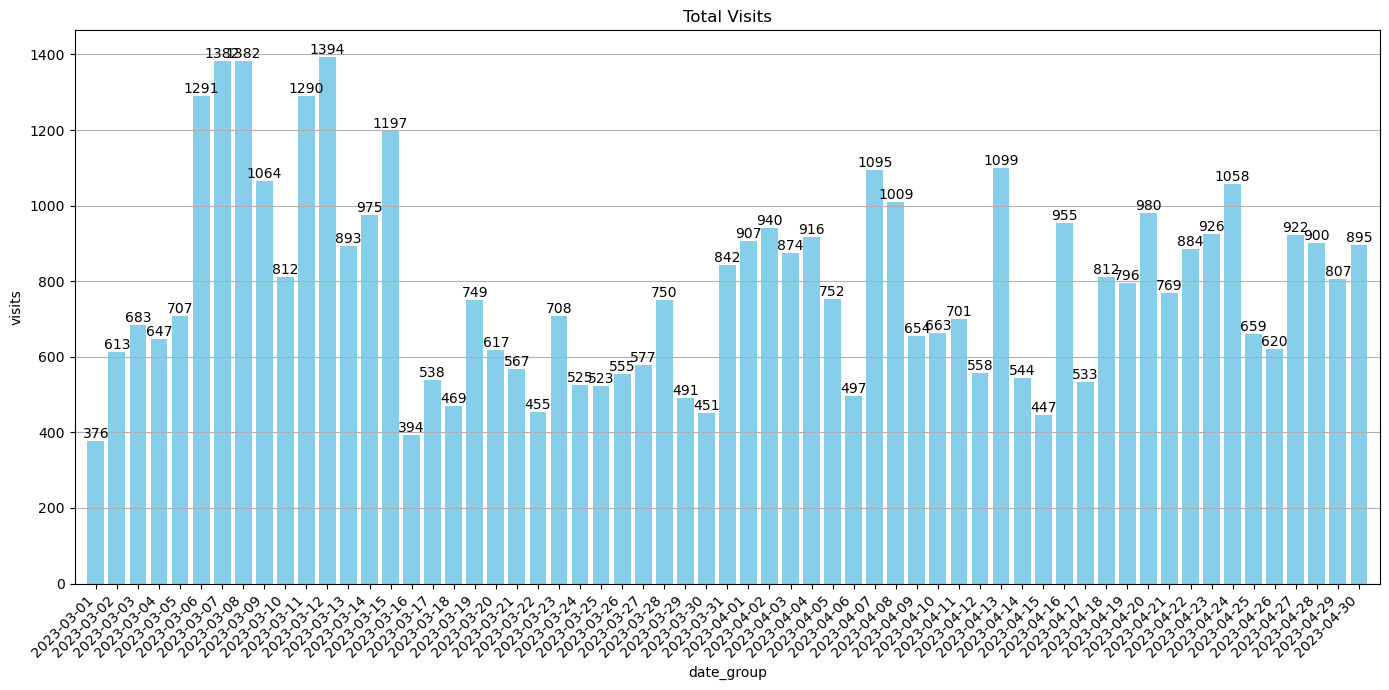

In [162]:
#Группируем посещения по дате
data = df_by_dates.groupby('date_group')['visits'].sum().reset_index()

#Создаем график
plt.figure(figsize=(14, 7))
bars = plt.bar(data['date_group'], data['visits'], color='skyblue')
plt.xlabel('date_group')
plt.ylabel('visits')
plt.title('Total Visits')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.xlim(-1, len(data['date_group']))
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')
plt.tight_layout()

#Сохраняем график в формате PNG
plt.savefig('./charts/total_visits.png')

#Отрисовываем график
plt.show()

# График "Итоговые визиты с разбивкой по платформам: web, android, ios"

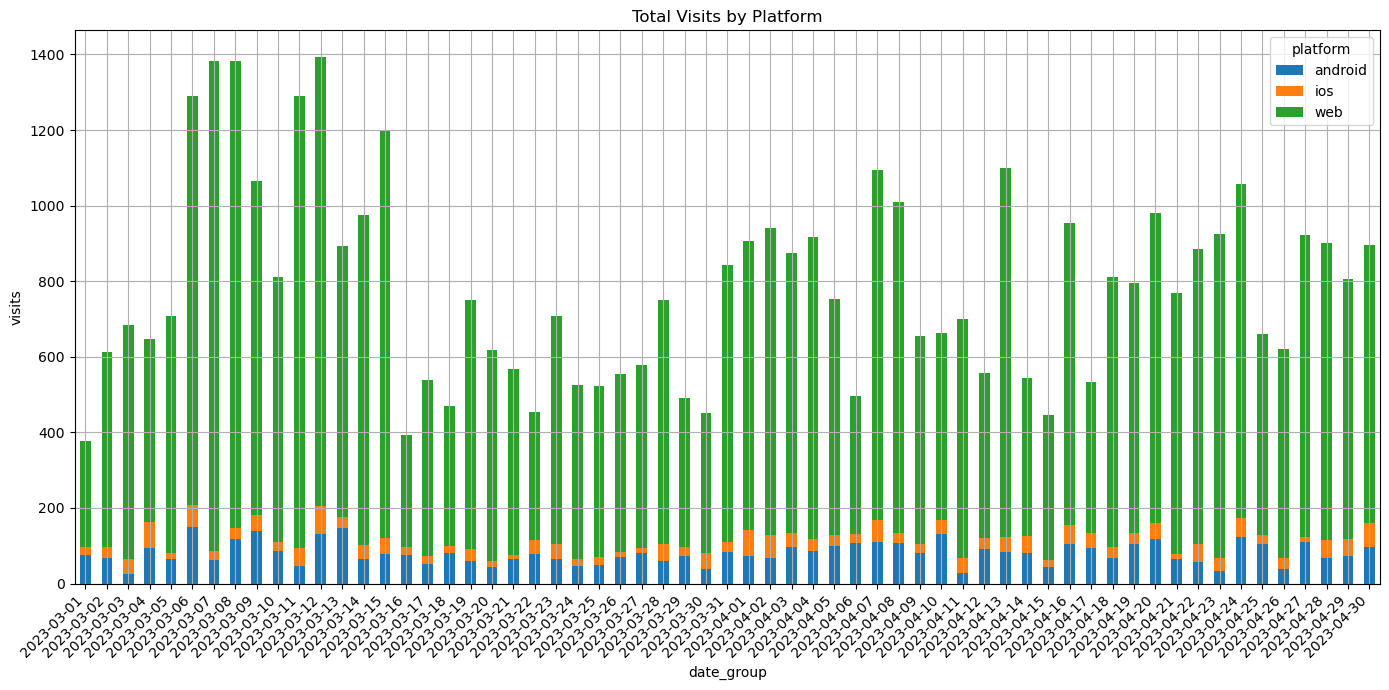

In [159]:
#Агрегируем данные
data = df_by_dates.pivot_table(values='visits', index='date_group', columns='platform', aggfunc='sum')

#Создаем график
fig, ax = plt.subplots(figsize=(14, 7))
data.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('date_group')
ax.set_title('Total Visits by Platform')
plt.xticks(rotation=45, ha='right')
ax.grid()
plt.tight_layout()

#Сохраняем график в формате PNG
plt.savefig('./charts/total_visits_by_platform.png')

#Отрисовываем график
plt.show()

# График "Итоговые регистрации"

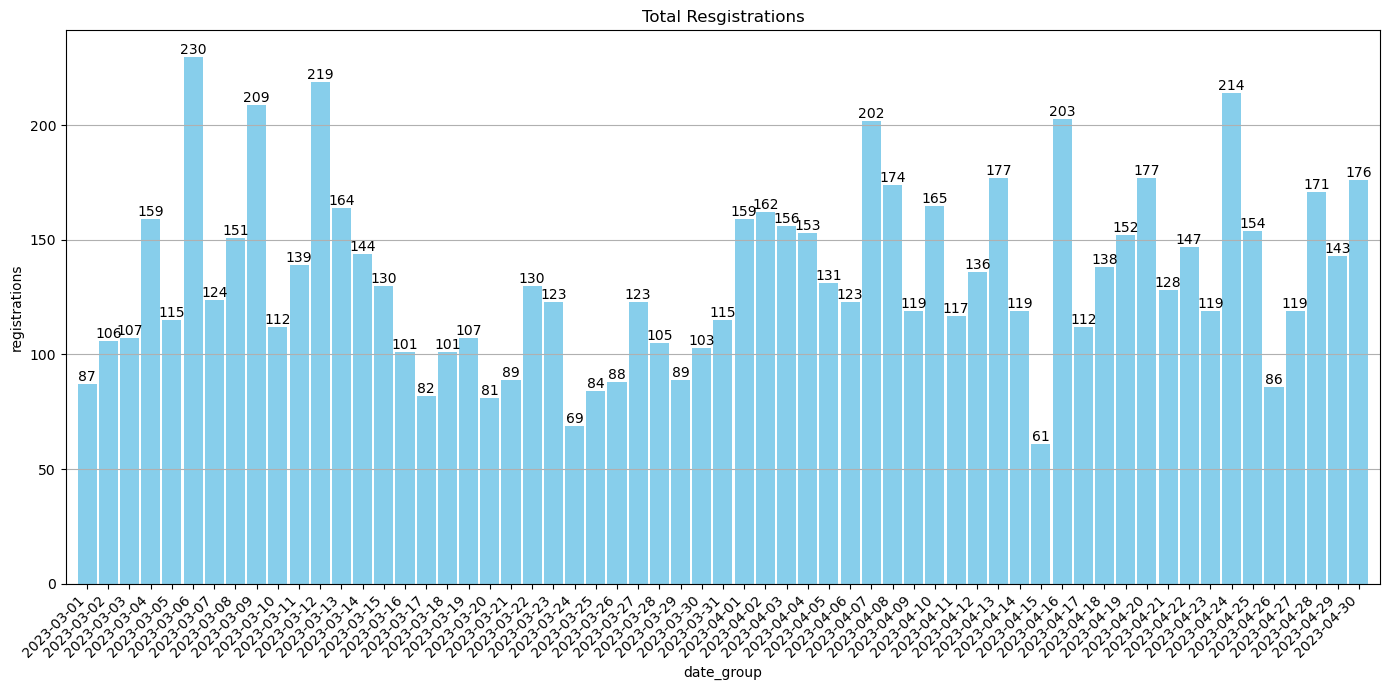

In [161]:
#Агрегируем данные
data = df_by_dates.groupby('date_group')['registrations'].sum().reset_index()

#Создаем график
plt.figure(figsize=(14, 7))
bars = plt.bar(data['date_group'], data['registrations'], color='skyblue', width=0.9)
plt.xlabel('date_group')
plt.ylabel('registrations')
plt.title('Total Resgistrations')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.xlim(-1, len(data['date_group']))
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', color='black')
plt.tight_layout()

#Сохраняем график в формате PNG
plt.savefig('./charts/total_resgistrations.png')

#Отрисовываем график
plt.show()

# График "Итоговые регистрации с разбивкой по платформе: web, android, ios"

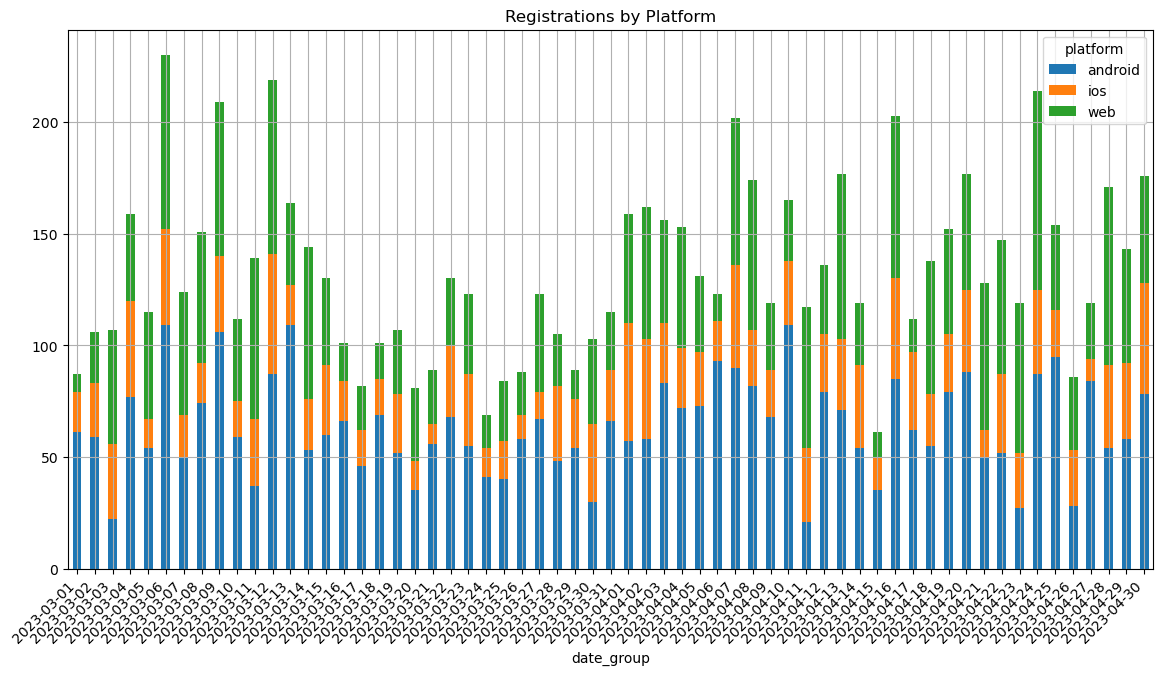

In [167]:
#Агрегируем данные
data = df_by_dates.pivot_table(values='registrations', index='date_group', columns='platform', aggfunc='sum')

#Создаем график
fig, ax = plt.subplots(figsize=(14, 7))
data.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('date_group')
ax.set_title('Registrations by Platform')
plt.xticks(rotation=45, ha='right')
ax.grid()

#Сохраняем график в формате PNG
plt.savefig('./charts/registrations_by_platform')

#Отрисовываем график
plt.show()

# График "Конверсия по каждой платформе"

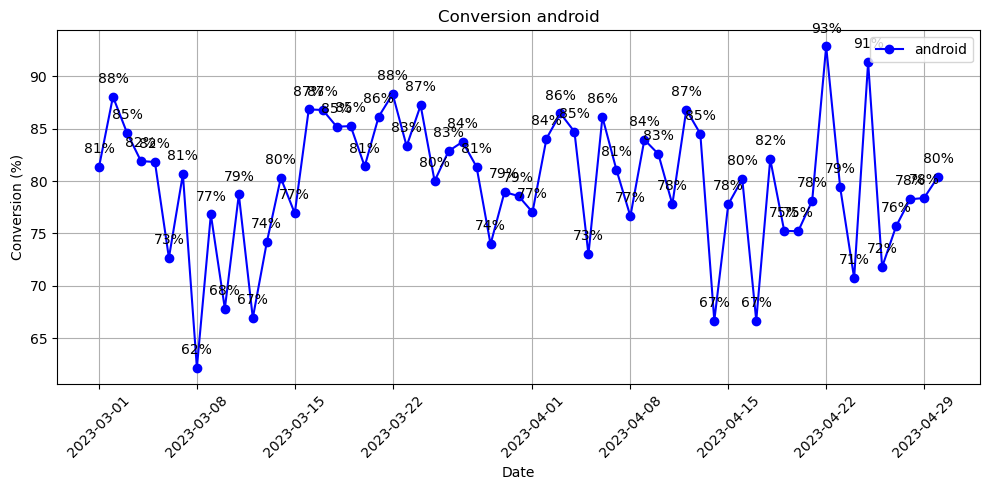

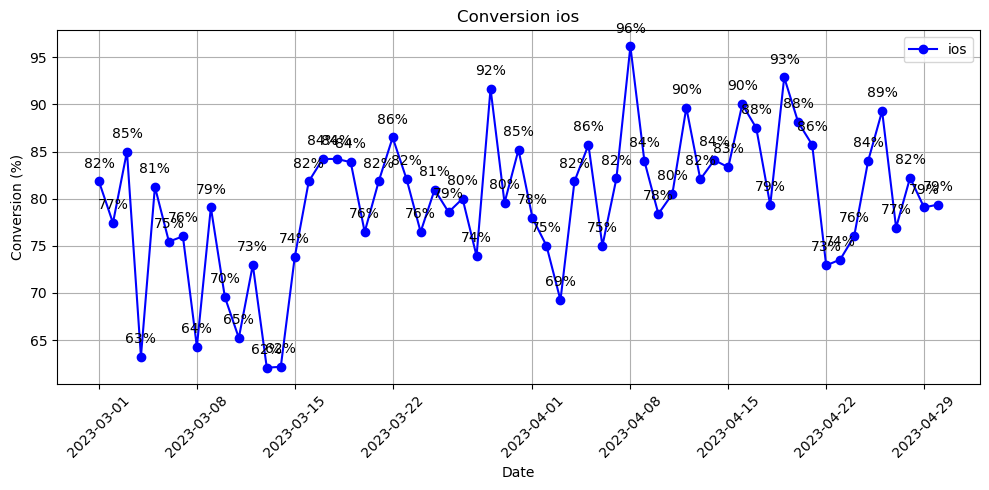

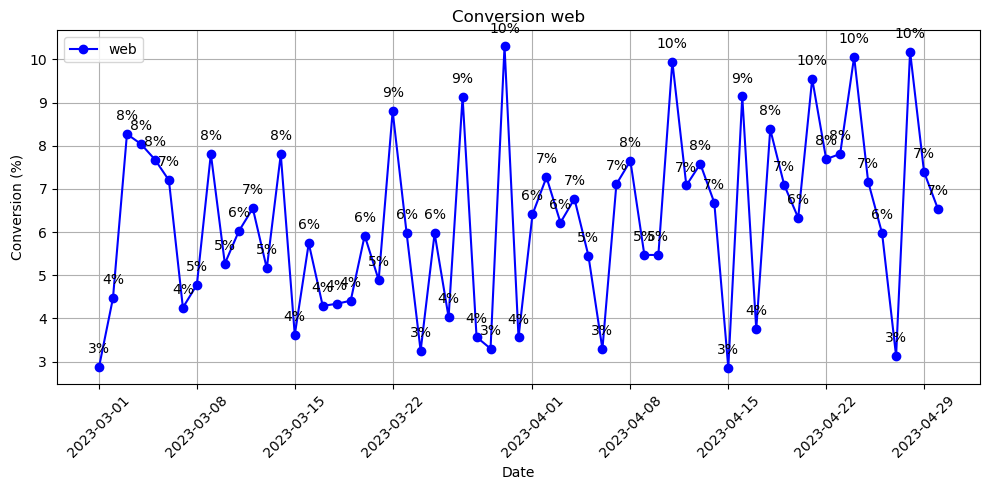

In [259]:
#Агрегируем данные для всех трех платформ
android_df = df_by_dates[df_by_dates['platform'] == 'android']
android_df.loc[:, 'conversion'] = android_df['conversion']

ios_df = df_by_dates[df_by_dates['platform'] == 'ios']
ios_df.loc[:, 'conversion'] = ios_df['conversion']

web_df = df_by_dates[df_by_dates['platform'] == 'web']
web_df.loc[:, 'conversion'] = web_df['conversion']

#Напишем функцию, которая принимает в качестве аргументов датафрейм и название платформы, она поможет нам отрисовать три одинаковых графика
def conversion_plot_builder(df, platform):
    #Создаем график
    plt.figure(figsize=(10, 5))
    plt.plot(df['date_group'], df['conversion'], marker='o', linestyle='-', color='blue', label=platform)
    for i, txt in enumerate(df['conversion']):
        plt.annotate(f'{txt:.0f}%', (df['date_group'].iloc[i], df['conversion'].iloc[i]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.title(f'Conversion {platform}')
    plt.xlabel('Date')
    plt.ylabel('Conversion (%)')
    plt.grid()
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(bymonthday=[1, 8, 15, 22]))
    plt.tight_layout()
    
    #Сохраняем график в формате PNG
    plt.savefig(f'./charts/conversion_{platform}')
    #Отрисовываем график
    plt.show()

#Вызываем нашу функцию
conversion_plot_builder(android_df, 'android')
conversion_plot_builder(ios_df, 'ios')
conversion_plot_builder(web_df, 'web')

# График "Средняя конверсия"

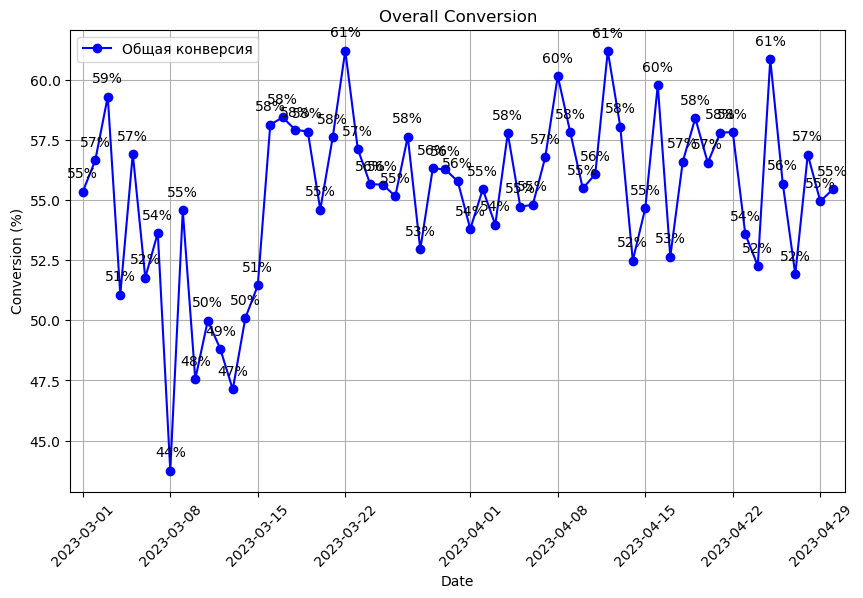

In [260]:
#Агрегируем данные
data = df_by_dates.groupby('date_group')['conversion'].mean().reset_index()

#Создаем график
plt.figure(figsize=(10, 6))
plt.plot(data['date_group'], data['conversion'], marker='o', linestyle='-', color='b', label='Общая конверсия')
for i, txt in enumerate(data['conversion']):
    plt.annotate(f'{txt:.0f}%', (data['date_group'][i], data['conversion'][i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.title('Overall Conversion')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(bymonthday=[1, 8, 15, 22]))
plt.xlim(-1, len(data['date_group']))
plt.grid() 
plt.legend() 

#Сохраняем график в формате PNG
plt.savefig('./charts/overall_conversion')

#Отрисовываем график
plt.show()

# График "Стоимости реклам"

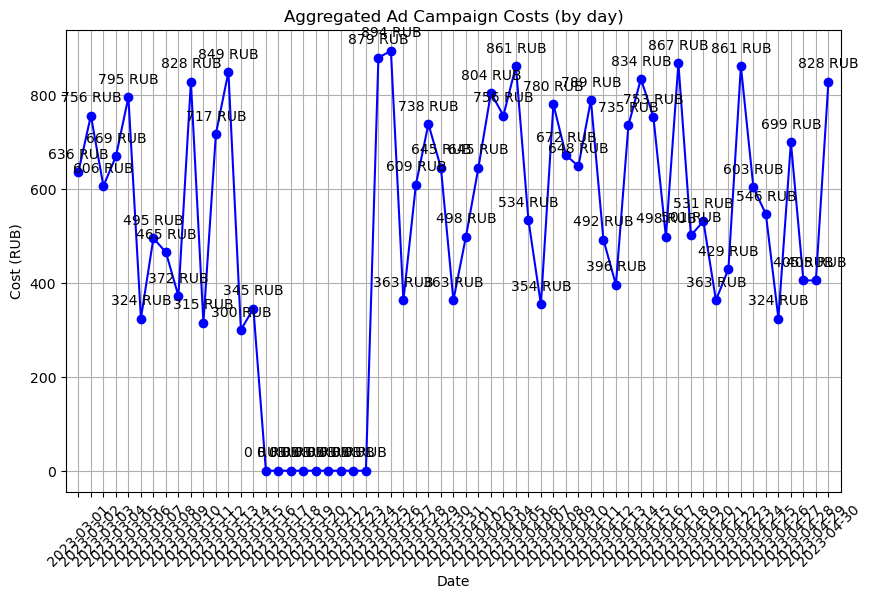

In [273]:
#Агрегируем данные
data = df_by_dates.groupby('date_group')['cost'].sum().reset_index()
#Создаем график
plt.figure(figsize=(10, 6))
plt.plot(data['date_group'], data['cost'], marker='o', linestyle='-', color='b')
for i, txt in enumerate(data['cost']):
    plt.annotate(f'{txt:.0f} RUB', (data['date_group'][i], data['cost'][i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Date')
plt.ylabel('Cost (RUB)')
plt.title('Aggregated Ad Campaign Costs (by day)')
plt.xticks(rotation=45)
plt.xlim(-1, len(data['date_group']))
plt.grid() 
#Сохраняем график в формате PNG
plt.savefig('./charts/aggregated_ad_campaign_costs.png')

#Отрисовываем график
plt.show()

# График "Визиты за весь период с цветовым выделением рекламной кампании"

In [ ]:
#Агрегируем данные
data = df_by_dates
#Создаем график

#Сохраняем график в формате PNG
plt.savefig('./charts/')

#Отрисовываем график
plt.show()

# График "Регистрации за весь период с цветовым выделением рекламной кампании"

In [ ]:
#Агрегируем данные
data = df_by_dates
#Создаем график

#Сохраняем график в формате PNG
plt.savefig('./charts/')

#Отрисовываем график
plt.show()